In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [10]:
## credits to  Alankritamishra
##  https://www.kaggle.com/code/alankritamishra/pytorchann
## https://github.com/Bjarten/early-stopping-pytorch.git
## Patrick Loeber

In [11]:
## Note you can play with optimizer and hidden layer for better results.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Outcome', ylabel='count'>

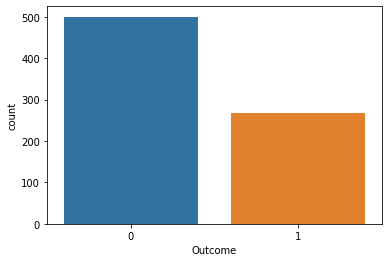

In [15]:
sns.countplot(df['Outcome'])

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


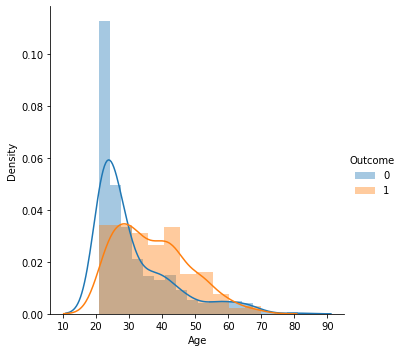

In [16]:
sns.FacetGrid(df , hue = 'Outcome' , size = 5 ).map(sns.distplot , 'Age').add_legend()
plt.show()

<AxesSubplot:>

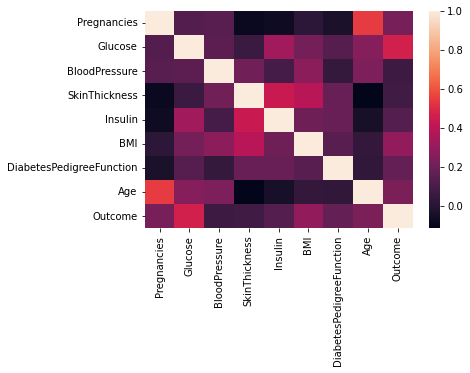

In [17]:
sns.heatmap(df.corr())

In [18]:
X= df[df.columns.difference(['Outcome'])].copy()
X.head()

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
0,50,33.6,72,0.627,148,0,6,35
1,31,26.6,66,0.351,85,0,1,29
2,32,23.3,64,0.672,183,0,8,0
3,21,28.1,66,0.167,89,94,1,23
4,33,43.1,40,2.288,137,168,0,35


In [19]:
from sklearn.model_selection import train_test_split

trainx , testx , trainy , testy = train_test_split(X , df['Outcome'] , random_state = 0 , test_size = 0.25)

In [20]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(576, 8)
(192, 8)
(576,)
(192,)


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , Dataset
import torch.nn.functional as F

In [22]:
##Dataloader
class train_loader(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(trainx.values.astype(np.float32))
        self.y = torch.from_numpy(trainy.values.astype(np.float32))
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self , index):
        return self.x[index] , self.y[index]
            
    def __len__(self):
        return self.n_samples

class val_loader(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(testx.values.astype(np.float32))
        self.y =  torch.from_numpy(testy.values.astype(np.float32))
        
    def __getitem__(self , index):
        return self.x[index] , self.y[index]
    
    def __len__(self):
        return self.x.shape[0]
    
    

In [23]:
train = train_loader()
traindataloader = DataLoader(train , batch_size = 16 )

In [24]:
len(traindataloader)

36

In [25]:
val = val_loader()
valdataloader = DataLoader(val , batch_size = 1)

In [26]:
## model
class neural_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8 , 64)
        self.linear2 = nn.Linear(64 , 32)
        self.linear3 = nn.Linear(32 , 16)
        self.linear4 = nn.Linear(16 , 1)
        self.dropout =  nn.Dropout(0.2)
    def forward(self , x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x =  F.relu(self.linear2(x))
        x = self.dropout(x)
        x = F.relu(self.linear3(x))
        x = self.dropout(x)
        x = F.relu(self.linear4(x))
        x = torch.sigmoid(x)
        return x
    
    

In [27]:
torch.manual_seed(0)
model = neural_net()

In [28]:
## Early Stopping
class EarlyStopping:
    
    def __init__(self, patience=7, verbose=False, delta=0, path='/kaggle/working/checkpoint.pt', trace_func=print):
                 
      
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [29]:
model.parameters

<bound method Module.parameters of neural_net(
  (linear1): Linear(in_features=8, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>

In [30]:
num_epochs = 10000
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters() , lr = 0.01)


In [31]:
## training
def training(model , patience , n_epochs):
    avg_train_loss = []
    avg_val_loss = []
    train_loss = []
    val_loss = []
    
    early_stop = EarlyStopping(patience = patience  , verbose = True)
    for epoch in range(num_epochs):
        model.train()
        for i , (x , label) in enumerate(traindataloader):
            label = label.unsqueeze(1)
            label = label.float()
            y_pred = model(x)
            loss = loss_fn(y_pred , label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss.append(loss.item())
        model.eval()
        for i , (x ,label) in enumerate(valdataloader):
            label = label.unsqueeze(1)
            label = label.float()
            y_pred = model(x)
            loss = loss_fn(y_pred , label)
            val_loss.append(loss.item())
            
        val_l = np.average(val_loss)
        train_l  = np.average(train_loss)
        
        avg_val_loss.append(val_l)
        avg_train_loss.append(train_l)
        print('Epoch : {} , train loss {} , val loss {}'.format(epoch , train_l , val_l))
        train_loss = []
        val_loss = []
        
        early_stop(val_l , model)
        if early_stop.early_stop:
            print('Stopping')
            break
            
    model.load_state_dict(torch.load('/kaggle/working/checkpoint.pt'))
    return model , avg_val_loss , avg_train_loss
        
    
    
            

In [32]:
model , valid_loss , train_loss = training(model , 20 , num_epochs)

Epoch : 0 , train loss 0.7302504231532415 , val loss 0.6931471824645996
Validation loss decreased (inf --> 0.693147).  Saving model ...
Epoch : 1 , train loss 0.693208826912774 , val loss 0.6931471824645996
Validation loss decreased (0.693147 --> 0.693147).  Saving model ...
Epoch : 2 , train loss 0.6972145752774345 , val loss 0.6931471824645996
Validation loss decreased (0.693147 --> 0.693147).  Saving model ...
Epoch : 3 , train loss 0.6928308556477228 , val loss 0.6931471824645996
Validation loss decreased (0.693147 --> 0.693147).  Saving model ...
Epoch : 4 , train loss 0.693341538310051 , val loss 0.6931471824645996
Validation loss decreased (0.693147 --> 0.693147).  Saving model ...
Epoch : 5 , train loss 0.6934419473012289 , val loss 0.6931471824645996
Validation loss decreased (0.693147 --> 0.693147).  Saving model ...
Epoch : 6 , train loss 0.6928981393575668 , val loss 0.6931471824645996
Validation loss decreased (0.693147 --> 0.693147).  Saving model ...
Epoch : 7 , train lo

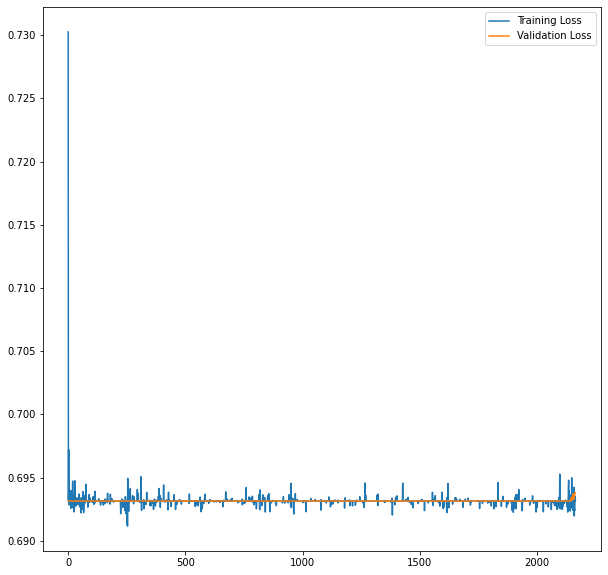

In [37]:
##plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss,label='Validation Loss')
plt.legend()
plt.show()

In [39]:
##loading model
ml = neural_net()
ml.load_state_dict(torch.load('/kaggle/working/checkpoint.pt'))

<All keys matched successfully>

In [40]:
##val accuracy
correct = 0

model.eval() # prep model for evaluation

for data, target in valdataloader:
    
    # forward pass: compute predicted outputs by passing inputs to the model
    output = ml(data)
    output = output.item()
    if output > 0.5 :
      output = 1 
    else :
      output = 0

    


    correct += (output == target).float().sum()
accuracy = 100 * correct / len(valdataloader.dataset)
print("Accuracy = {}".format(accuracy))
    

Accuracy = 67.70833587646484
